# Contextual MAB experiment POC

In this notebook we will simulate a multi armed bandit experiment, similar to what we could expect when analyzing marketing campaigns, and apply different techniques to solve it.

The notebook has the following structure

1. [Modules loading](#Modules-loading)
2. [Experimental data generation](#Experimental-data-generation)
    * [Creating groups](#Creating-groups)
3. [ABC greedy](#ABC-greedy)
4. [Thompson Sampling](#Thompson-Sampling)
5. [Contextual Thompson Sampling](#Contextual-Thompson-Sampling)
    * [Bayesian Logistic](#Bayesian-Logistic)
6. [Cohort space reconstruction](#Cohort-space-reconstruction)
    * [group 1](#group-1)
    * [group 2](#group-2) 
    * [group 3](#group-3)    

## Modules loading

In [1]:
import os
import sys
sys.path.append('/Users/fci02/Documents/GitHub/decisioning-analysis/test_and_learn/production_modules/')

import numpy as np
import pandas as pd

from scipy.stats import f_oneway
from tqdm import tqdm

from contextual_mab.experiments.framework import MABFramework
from contextual_mab.experiments.framework import run_experiment
from contextual_mab.data_utils.data_generation  import generate_synthetic_trial_data
from contextual_mab.data_utils.data_generation  import generate_experimental_dataset

import matplotlib.pyplot as plt
import seaborn as sns

## Experimental data generation

We generate 3 groups of customers, characterized by different attributes distributions, and with different **overall** preferred action 

### Creating groups

In [2]:
seed=0

#### group 1

This cohort has the following properties:
1. contains customers with age between 30 and 37 years, equally distributed
2. 60% of customers have one kid at home, 20% two, 20% three
3. 30% of customers are SGE active
4. 40% of customers are MS active
5. 40% of them live in a detached house, 10% in a semi-detached, 50% in a flat
6. Overall, customers do prefer the first action, with an overall pick up rate of roughly 8%
7. 10K customers

In [3]:
n_1 = 10000
noise_scale_1=5.

cw_1 = [.09,.08,.06]

ct_prm_1 = {}

ord_prm_1 = {'n_kids_in_house':{'start':1,'stop':6,'weights':[.6,.2,.2,0.,0.]},
             'Age':{'start':30,'stop':37,'weights':[1./7]*7}}

catg_prm_1 = {'SGE_Active':{'levels':['Yes','No'],'weights':[.3,.7]},
              'MS_Active':{'levels':['Yes','No'],'weights':[.4,.6]},
              'House_type':{'levels':['Detached','SemiDetached','Flat'],'weights':[.4,.1,.5]}}

weights_1 = [[-0.85427315,  -1.16572722,  0.8890073,  -0.57988417, 0.15193386, 
              -0.28800726, 0.06606457],
             [ 0.46719077, -1.64435559,  0.69791627, -0.14981489,  0.26023682,  
               0.67528998, 1.52150038],
             [ -1.62075116, 0.15865047, 0.85728784,  1.23667642, 0.58707557,
               0.05713119, 0.47387454]]

In [4]:
cohort_1 = generate_synthetic_trial_data(n_1,3,cw_1,ct_prm_1,ord_prm_1,catg_prm_1,0,noise_scale_1,weights_1)

In [5]:
action_cols = ['action_{}_reward'.format(idx) for idx in range(1,4)]

In [6]:
cohort_1[action_cols].mean()

action_1_reward    0.0817
action_2_reward    0.0439
action_3_reward    0.0408
dtype: float64

#### group 2

This cohort has the following properties:
1. contains customers with age between 18 and 25 years, unevenly distributed
2. 90% of customers do not have children, 5% have one, 5% two
3. 80% of customers are SGE active
4. 50% of customers are MS active
5. 10% of them live in a detached house, 10% in a semi-detached, 80% in a flat
6. Overall, customers do prefer the second action, with an overall pick up rate of roughly 9%
7. 3K customers

In [499]:
n_2 = 3000
noise_scale_2=5.

cw_2 = [.06,.12,.04]

ct_prm_2 = {}

ord_prm_2 = {'n_kids_in_house':{'start':0,'stop':5,'weights':[.9,.05,.05,0.,0.]},
             'Age':{'start':18,'stop':25,'weights':[.05,.05,.1,.3,.2,.2,.1]}}

catg_prm_2 = {'SGE_Active':{'levels':['Yes','No'],'weights':[.8,.2]},
              'MS_Active':{'levels':['Yes','No'],'weights':[.5,.5]},
              'House_type':{'levels':['Detached','SemiDetached','Flat'],'weights':[.1,.1,.8]}}

weights_2 = [[-0.85427315,  -1.16572722,  0.8890073,  -0.57988417, 0.15193386, 
              -0.28800726, 0.06606457],
             [ 0.46719077, -1.64435559,  0.69791627, -0.14981489,  0.26023682,  
               0.67528998, 1.52150038],
             [ -1.62075116, 0.15865047, 0.85728784,  1.23667642, 0.58707557,
               0.05713119, 0.47387454]]

In [500]:
cohort_2 = generate_synthetic_trial_data(n_2,3,cw_2,ct_prm_2,ord_prm_2,catg_prm_2,0,noise_scale_2,weights_2)

In [501]:
cohort_2[action_cols].mean()

action_1_reward    0.057000
action_2_reward    0.092000
action_3_reward    0.039333
dtype: float64

#### group 3

This cohort has the following properties:
1. contains customers with age between 40 and 45 years,  evenly distributed
2. 90% of customers do not have children, 5% have one, 5% two
3. 50% of customers are SGE active
4. 80% of customers are MS active
5. 10% of them live in a detached house, 30% in a semi-detached, 60% in a flat
6. Overall, customers do prefer the thirdaction, with an overall pick up rate of roughly 9%
7. 7K customers

In [505]:
n_3 = 7000
noise_scale_3=5.

cw_3 = [.06,.06,.1]

ct_prm_3 = {}

ord_prm_3 = {'n_kids_in_house':{'start':0,'stop':5,'weights':[.9,.05,.05,0.,0.]},
             'Age':{'start':40,'stop':50,'weights':[.1]*10}}

catg_prm_3 = {'SGE_Active':{'levels':['Yes','No'],'weights':[.5,.5]},
              'MS_Active':{'levels':['Yes','No'],'weights':[.8,.2]},
              'House_type':{'levels':['Detached','SemiDetached','Flat'],'weights':[.1,.3,.6]}}

weights_3 = [[-1.85427315,  -1.16572722,  0.4090073,  0.77988417, 0.15193386, 
              -0.28800726, 0.006606457],
             [ -0.46719077, -1.64435559,  0.40791627, 0.14981489,  0.26023682,  
               -0.67528998, 1.52150038],
             [ -1.62075116, -0.15865047, 0.40728784,  0.83667642, 0.58707557,
               -0.05713119, 0.47387454]]

In [506]:
cohort_3 = generate_synthetic_trial_data(n_3,3,cw_3,ct_prm_3,ord_prm_3,catg_prm_3,0,noise_scale_3,weights_3)

In [507]:
cohort_3[action_cols].mean()

action_1_reward    0.053000
action_2_reward    0.057714
action_3_reward    0.089857
dtype: float64

In [508]:
experiment_data = generate_experimental_dataset([n_1,n_2,n_3],
                                                [cw_1,cw_2,cw_3],
                                                [ct_prm_1,ct_prm_2,ct_prm_3],
                                                [ord_prm_1,ord_prm_2,ord_prm_3],
                                                [catg_prm_1,catg_prm_2,catg_prm_3],
                                                [noise_scale_1,noise_scale_2,noise_scale_3],
                                                [weights_1,weights_2,weights_3],
                                                seed,
                                                output_info=True)

Group 1


action_1_reward    0.0817
action_2_reward    0.0439
action_3_reward    0.0408
dtype: float64

Group 2


action_1_reward    0.057000
action_2_reward    0.092000
action_3_reward    0.039333
dtype: float64

Group 3


action_1_reward    0.053000
action_2_reward    0.057714
action_3_reward    0.089857
dtype: float64

Overall


action_1_reward    0.06795
action_2_reward    0.05595
action_3_reward    0.05775
dtype: float64

### ABC greedy

In [509]:
batch_size = 2000

run_experiment(experiment_data, batch_size, MABFramework,{'strategy':'static-one-fits-all','n_actions':3,'static_min_steps':2})

100%|██████████| 10/10 [00:00<00:00, 75.57it/s]


0.0652

### Thompson Sampling

In [510]:
run_experiment(experiment_data, batch_size, MABFramework,{'strategy':'dynamic-one-fits-all','n_actions':3,'alphas':[1.,1.,1.],'betas':[1.,1.,1.]})

100%|██████████| 10/10 [00:00<00:00, 67.43it/s]


0.06555

### Contextual Thompson Sampling
#### Bayesian Logistic

In [511]:
from contextual_mab.predictive_models.bayesian_logistic import BayesianLogisticRegression

In [512]:
action_cols = [column for column in experiment_data.columns if 'action' in column]
predictors = pd.get_dummies(experiment_data.drop(columns=action_cols),drop_first=True).columns.tolist()
predictors

['n_kids_in_house',
 'Age',
 'SGE_Active_Yes',
 'MS_Active_Yes',
 'House_type_Flat',
 'House_type_SemiDetached']

In [513]:
exp_obj = run_experiment(experiment_data, batch_size, MABFramework,{'strategy':'contextual-one-fits-one','n_actions':3,
                                                          'modelling_approach':BayesianLogisticRegression,
                                                          'modelling_approach_pms':{'n_samples':500,'n_chains':2,
                                                                                    'predictors':predictors.copy(),
                                                                                    'tune':1000,
                                                                                    'check_prog':False}},
                          return_exp_obj=True)

  0%|          | 0/10 [00:00<?, ?it/s]Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [House_type_SemiDetached, House_type_Flat, MS_Active_Yes, SGE_Active_Yes, Age, n_kids_in_house, Intercept]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [House_type_SemiDetached, House_type_Flat, MS_Active_Yes, SGE_Active_Yes, Age, n_kids_in_house, Intercept]
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [House_type_SemiDetached, House_type_Flat, MS_Active_Yes, SGE_Active_Yes, Age, n_kids_in_house, Intercept]
 20%|██        | 2/10 [00:44<02:57, 22.23s/it]Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [House_type_SemiDetached, House_type_Flat, MS_Active_Yes, SGE_Active_Yes, Age, n_kids_in_house, Intercept]
Auto-assigning N

In [514]:
exp_obj.current_data.reward.mean()

0.0818

The conversion rates for ABC greedy and Thompson Sampling are quite similar (6.5%), while for the contextual Thompson Sampling we have an improvement of 30% (conversion rate 8%) 

## Cohort space reconstruction

Can we use the action codes assigned by the contextual Thompson Sampling to reconstruct the original cohorts?

### group 1

In [521]:
features = cohort_1.drop(columns=action_cols).columns

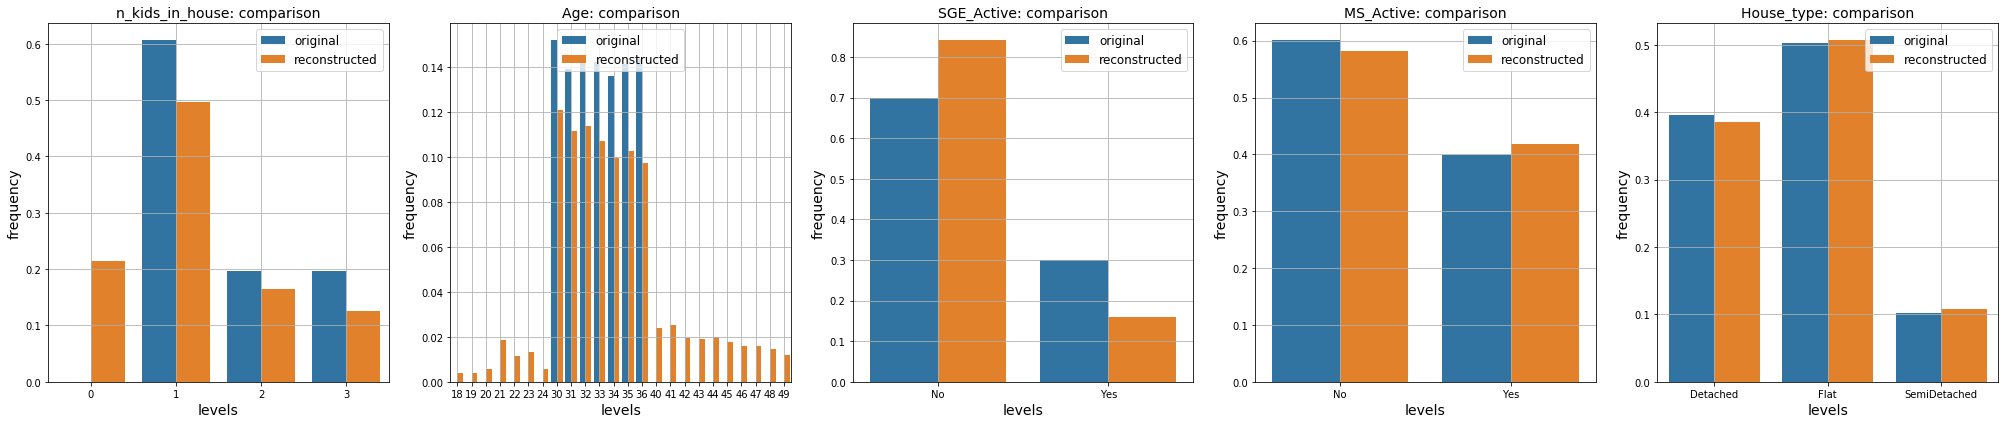

In [553]:
idx = 0
cohort = cohort_1
subset = exp_obj.current_data[exp_obj.current_data.action_code==idx]
    
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(28,6))
for feature, ax in zip(features,(ax1, ax2, ax3, ax4, ax5)):

    original = cohort.groupby(feature).count()
    original = original[[original.columns[0]]]
    original = original/original.sum()
    original.rename(columns={original.columns[0]:'prop'},inplace=True)
    original['flag']='original'

    reconstructed = subset.groupby(feature).count()
    reconstructed = reconstructed[[reconstructed.columns[0]]]
    reconstructed.rename(columns={reconstructed.columns[0]:'prop'},inplace=True)
    reconstructed = reconstructed/reconstructed.sum()
    reconstructed['flag']='reconstructed'

    comparison = pd.concat([original,reconstructed])
    comparison[feature] = comparison.index.values
    sns.barplot(x=feature,y='prop',data=comparison,hue='flag',ax=ax)
    ax.set_ylabel('frequency',fontsize=14)
    ax.set_xlabel('levels',fontsize=14)
    ax.set_title('{}: comparison'.format(feature), fontsize=14)
    ax.legend(fontsize=12)
    ax.grid()
plt.tight_layout()
plt.show()

In [523]:
subset.reward.mean()

0.0766562608394034

In [525]:
subset.shape

(8649, 7)

### group 2

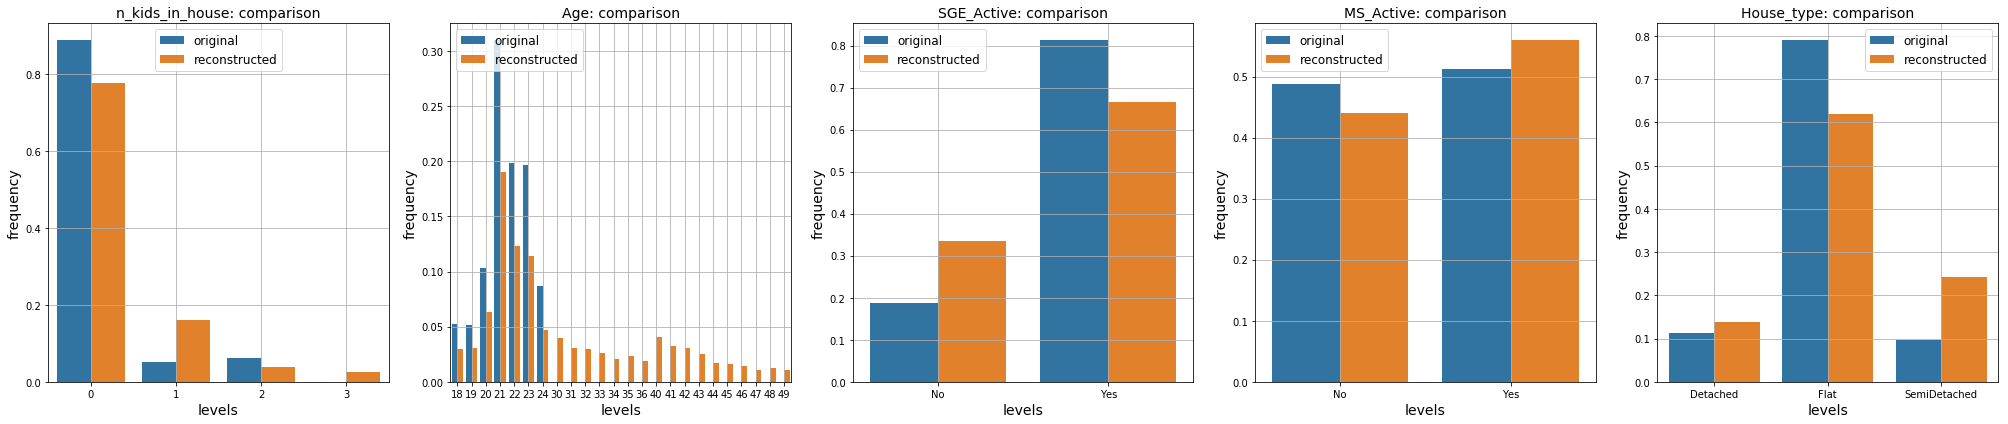

In [549]:
idx = 1
cohort = cohort_2
subset = exp_obj.current_data[exp_obj.current_data.action_code==idx]
    
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(28,6))
for feature, ax in zip(features,(ax1, ax2, ax3, ax4, ax5)):

    original = cohort.groupby(feature).count()
    original = original[[original.columns[0]]]
    original = original/original.sum()
    original.rename(columns={original.columns[0]:'prop'},inplace=True)
    original['flag']='original'

    reconstructed = subset.groupby(feature).count()
    reconstructed = reconstructed[[reconstructed.columns[0]]]
    reconstructed.rename(columns={reconstructed.columns[0]:'prop'},inplace=True)
    reconstructed = reconstructed/reconstructed.sum()
    reconstructed['flag']='reconstructed'

    comparison = pd.concat([original,reconstructed])
    comparison[feature] = comparison.index.values
    sns.barplot(x=feature,y='prop',data=comparison,hue='flag',ax=ax)
    ax.set_ylabel('frequency',fontsize=14)
    ax.set_xlabel('levels',fontsize=14)
    ax.set_title('{}: comparison'.format(feature), fontsize=14)
    ax.legend(fontsize=12)
    ax.grid()
plt.tight_layout()
plt.show()

In [527]:
subset.reward.mean()

0.08125992588671255

In [528]:
subset.shape

(3778, 7)

### group 3

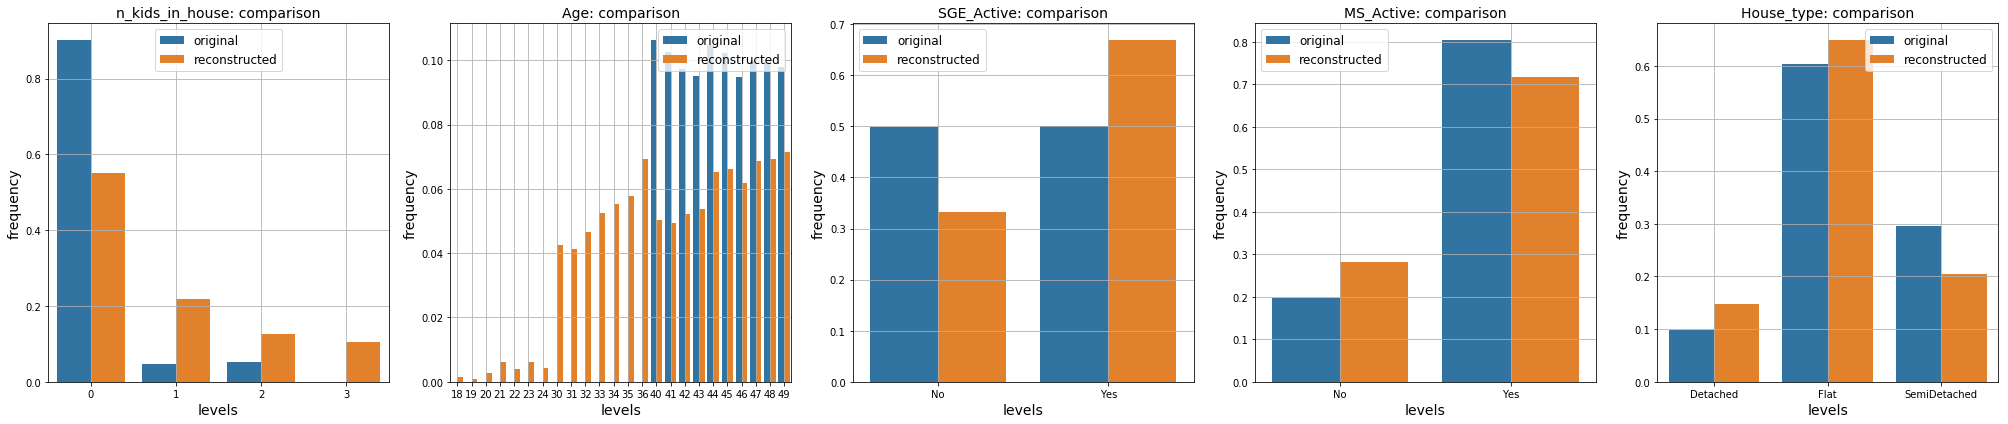

In [550]:
idx = 2
cohort = cohort_3
subset = exp_obj.current_data[exp_obj.current_data.action_code==idx]
    
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5,figsize=(28,6))
for feature, ax in zip(features,(ax1, ax2, ax3, ax4, ax5)):

    original = cohort.groupby(feature).count()
    original = original[[original.columns[0]]]
    original = original/original.sum()
    original.rename(columns={original.columns[0]:'prop'},inplace=True)
    original['flag']='original'

    reconstructed = subset.groupby(feature).count()
    reconstructed = reconstructed[[reconstructed.columns[0]]]
    reconstructed.rename(columns={reconstructed.columns[0]:'prop'},inplace=True)
    reconstructed = reconstructed/reconstructed.sum()
    reconstructed['flag']='reconstructed'

    comparison = pd.concat([original,reconstructed])
    comparison[feature] = comparison.index.values
    sns.barplot(x=feature,y='prop',data=comparison,hue='flag',ax=ax)
    ax.set_ylabel('frequency',fontsize=14)
    ax.set_xlabel('levels',fontsize=14)
    ax.set_title('{}: comparison'.format(feature), fontsize=14)
    ax.legend(fontsize=12)
    ax.grid()
plt.tight_layout()
plt.show()

In [659]:
from sklearn.ensemble import RandomForestClassifier

In [680]:
input_cols = exp_obj.current_data.drop(columns=['reward', 'action_code']).columns
dummy_cols = pd.get_dummies(exp_obj.current_data[input_cols],drop_first=True).columns
X = pd.get_dummies(exp_obj.current_data[input_cols],drop_first=True).values
y = exp_obj.current_data['action_code'].values

In [681]:
forest = RandomForestClassifier(n_estimators=300,max_depth=5, min_samples_leaf=1000)

In [683]:
forest.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1000, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [686]:
importance_frame = pd.DataFrame(data=forest.feature_importances_,
                                columns=['importance'],
                               index=dummy_cols)
display(importance_frame.sort_values(by=['importance'],ascending=False))

importance
Age                        0.401953
SGE_Active_Yes             0.363103
n_kids_in_house            0.136683
MS_Active_Yes              0.072491
House_type_Flat            0.015770
House_type_SemiDetached    0.010000

Let us just try to use the top three features to describe our customer cohorts

In [687]:
from sklearn.tree import DecisionTreeClassifier

ruler = DecisionTreeClassifier(max_depth=5,min_samples_leaf=1000)
X = pd.get_dummies(exp_obj.current_data[['Age','n_kids_in_house','SGE_Active']],drop_first=True,).values
y = exp_obj.current_data['action_code'].values
ruler.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1000, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [690]:
from sklearn.tree import export_graphviz
from IPython.display import Image
from subprocess import call

export_graphviz(ruler, 
                out_file='tree.dot', 
                feature_names = ['Age','n_kids_in_house','SGE_Active_Yes'],
                class_names = ['0','1','2'],
                rounded = True, proportion = False, 
                precision = 2, filled = True,special_characters=True)

call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=800'])
display(Image(filename = 'tree.png'))

In [693]:
np.unique(ruler.predict(X), return_counts=True)

(array([0, 1, 2]), array([8955, 2436, 8609]))

We can more or less reconstruct th3e cohorts by using an approach similar to the one used to build the CCP tool